In [20]:


#!jupyter nbconvert --output-dir='./results/' --to pdf --no-input umda-pbil-geneticnds-mimic-feda.ipynb  # pdf, html, latex


In [36]:


import json
import pandas as pd
import re
import numpy as np


pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 15)

keep_metrics = ['HV', 'spread', 'gdplus','time','nds_update_time']

datasets_names = ['p1', 'p2', 's1', 's2', 's3']  
algorithms = ['GRASP', 'umda', 'pbil', 'geneticNDS', 'mimic'] 

files_container = '../output/files_list_soco_umda-pbil-GRASP-geneticnds-mimic' # #  generated by running extract_postMetrics.py



## 1 Datasets

In [22]:
import sys  
sys.path.insert(0, '../datasets')
from Dataset import Dataset

ds_summary = pd.DataFrame(columns=['Dataset', '#Stakeholders', '#PBI'])

for name in datasets_names:
    
    ds = Dataset(source_file='..\datasets\\'+ name+ '.json')
    n_pbis = ds.num_pbis
    n_stakeholders = len(ds.stakeholders_importances)

        
    new_row = {'Dataset': name, '#Stakeholders': n_stakeholders, '#PBI': n_pbis}
    ds_summary = ds_summary.append(new_row, ignore_index=True)

def row_color(val):
    
    if val < 2: color = 'background-color: yellow'

    return color


pd.set_option('display.float_format', '{:.3f}'.format)
display(ds_summary)
#print(ds_summary[0:17].to_latex(index=False))



,Dataset,#Stakeholders,#PBI
0,p1,5,20
1,p2,5,100
2,s1,15,40
3,s2,50,80
4,s3,100,140


In [23]:
import math

def getdf_with_params_and_metrics(files, keep_parameters):

    parameters_dictios_list = []
    metrics_dictios_list = []
    
    
    for file in files:
        with open(file, 'r') as f:
            dictio = json.load(f)
            parameters_dictios_list.append(dictio['parameters'])
            metrics_dictios_list.append(dictio['metrics'])
        
            

    parameters_df= pd.DataFrame(parameters_dictios_list)
    parameters_df = parameters_df[['dataset'] + keep_parameters]

    metrics_df = pd.DataFrame(metrics_dictios_list)
    
    metrics_df = metrics_df[keep_metrics]
    #lists = metrics_df['gdplus']
    #for l in lists:
     #   for x in l:
      #      if isinstance(x, str): print(x, l)

    
    for column in keep_metrics: #we have several runs for each metric (list of values in each cell), so compute mean
        #metrics_df[column] = pd.DataFrame(metrics_df[column].values.tolist())
        metrics_df[column] = pd.DataFrame(metrics_df[column].values.tolist()).mean(axis=1)
    #display(metrics_df)
    combined_df=parameters_df.join(metrics_df)
    combined_df['file']=files

    return combined_df

In [24]:
import pandas as pd
import re

# Counts the number of wins (HV by default) for each configuration in data_df of the given hyperparameters.
# Each win is computed from results for a dataset
# returns:
#    dictionary with the, most frequently, best configuration. if ties, then first occurrence is returned
#    dictionary with the count of configuration which were the best at leats once
#    number of datasets    
# 
def get_best_configuration(data_df, hyperparameters, metric: str = 'HV') -> dict:
    
    dataset_groups = data_df.groupby(['dataset'])
    best_configs_counts = {}


    for group in dataset_groups: # find best hyperparameters config
        #print(group)
        group_df = pd.DataFrame(group[1])
        max_index = group_df[metric].idxmax()
        best_config = (group[1][hyperparameters]).loc[max_index]
        dataset_name = (group[1]['dataset']).loc[max_index] #any row
        file_name = (group[1]['file']).loc[max_index] 
        
        key = best_config.to_string()
        besthv = round(group_df[metric].loc[max_index], 4)
        if key in best_configs_counts.keys():
            (count, list_datasets, list_hv, list_files) = best_configs_counts[key]
            list_datasets.extend([dataset_name])
            list_hv.extend([besthv])
            list_files.extend([file_name])
           
            best_configs_counts[key]= (count + 1, list_datasets, list_hv, list_files)
        else:
            best_configs_counts[key] = (1, [dataset_name], [besthv], [file_name])

           
    
    #print(best_configs_counts)
   # print(len(best_configs_counts))
    #print(best_configs_counts)
    v = list(best_configs_counts.values())
    k = list(best_configs_counts.keys())
    best_config = k[v.index(max(v))]

    #convert string of best config to dictionary 
    best_config = re.sub(' +',' ',best_config)
    best_config = best_config.replace(' ',':')
    best_config = best_config.replace('\n',',')
    best = dict((x.strip(), y.strip())
             for x, y in (element.split(':') 
             for element in best_config.split(',')))
    return best, best_configs_counts, len(dataset_groups)
    
        

In [25]:
# convert dictionary counts of each best configuration to dataframe
def dictionary_keystring_to_dataframe(keep_parameters, best_counts):
    table_df = pd.DataFrame(columns=keep_parameters+['datasets'])
    for k in best_counts.keys():
        #print(f"{k} \n\t\t---> was the best config in: {best_counts[k]} datasets")
        row_dict = dict()
        for col in keep_parameters:
            start=k.index(col+' ')
            try: 
                end=k.index("\n", start)
            except: end = len(k)
            line = k[start:end]
            key = line[0:line.index(' ')]
            value = line[line.rfind(' ')+1:len(line)]
            row_dict[key]=value
        (counts, datasets_names, HVs, file_example) = best_counts[k]
        row_dict['datasets'] = datasets_names
        row_dict['HV'] = HVs
        row_dict['wins'] = int(counts)
        row_dict['file'] = file_example
        table_df = table_df.append(row_dict, ignore_index=True)
    return table_df

In [26]:
def print_hyperparams_values(df, hyperparmeters, algorithm):
    print(f"These are the different values used to set hyperparameters in {algorithm}, for each dataset:")
    mult = 1
    for hp in hyperparmeters:
        values = df[hp].unique()
        mult = mult * len(values)
        print(f"{hp}: {values}")
    print(f"In total, {mult} configuration per dataset.")

In [27]:
# create list of files with best configuration for a given algorithm
def get_files_list_with_best_configuration(best_for_algorithm_df, datasets_list):
    best_for_algorithm_df['wins'] = best_for_algorithm_df['wins'].astype(int)
    max_index = best_for_algorithm_df['wins'].idxmax()
    file_template = best_for_algorithm_df['file'].loc[max_index][0] #0 or any other if there is more than one file
    dataset_in_template =  best_for_algorithm_df['datasets'].loc[max_index][0]
    algorithm_files = [] #ordered by datasetname
    for dataset in datasets_list:
        file = file_template.replace(dataset_in_template, dataset, 1)
        algorithm_files.extend([file])
    return algorithm_files


In [28]:
def get_files_for_dataset(dataset_name):
    files = []
    with open(files_container, 'r') as f:
        for line in f:
            # todo: al haber metido en files_list los geneticos, resulta que tienen "p1" en todos los nombres por 'flip1bit', y elitismnds30 con s3.
            temp_line = line.replace("flip1bit", '')
            temp_line = temp_line.replace("elitismnds30", '')
            if dataset_name in temp_line: 
                files.append('../'+str(line.replace('\n','')))
    return files

## 2 Search of the best hyperparameters configuration for each algorithm, given SSS_per_iteration={False,True}

### 2.1 Best configuration for: GRASP


In [29]:
#filest_list_GRASP contains all output files from the GRASP algorithm. Goal is to find the best hyperparameters configuration.
# 
algorithm =  'GRASP'
if('GRASP' in files_container):

    keep_parameters = ['solutions_per_iteration', 'iterations', 'init_type', 'local_search_type', 'path_relinking_mode','sss_per_iteration']
    

    files = []
    with open(files_container, 'r') as f:
        for line in f:
             if algorithm in line:
                files.append('../'+str(line.replace('\n','')))

    
    df_grasp = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
    df_grasp = df_grasp[df_grasp.dataset.isin(datasets_names)]
    
    print_hyperparams_values(df_grasp, keep_parameters, "GRASP")

    #display(df_grasp)
    best_for_grasp_df = [None,None] # index 0 por sss_per_iteration=False, 1 for True
    values_sss = [False, True]
    for it in np.arange(0,len(values_sss)):

        df_filtered = df_grasp.loc[df_grasp['sss_per_iteration'] == values_sss[it]]

        best_config_grasp, best_counts, ndatasets= get_best_configuration(data_df=df_filtered, hyperparameters=keep_parameters, metric='HV')
     
        best_for_grasp_df[it]=dictionary_keystring_to_dataframe(keep_parameters=keep_parameters, best_counts=best_counts)

        print(f"\nCounts of best configurations found in {ndatasets} datasets. Please notice that those with less than the  maximum possible #iterations or "\
            "#solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' " \
            "can be interpreted as 'minimum configuration to converge'.")


        display(best_for_grasp_df[it].drop(['file'], axis=1, inplace=False))


        print(f"\nBest hyperparameter configuration for GRASP when sss_per_iteration={values_sss[it]}:")
        for param in best_config_grasp:
            print(f"{param}:{best_config_grasp[param]}")



    




These are the different values used to set hyperparameters in GRASP, for each dataset:
solutions_per_iteration: [ 100  200  500  700 1000]
iterations: [ 50 100 200 300 400]
init_type: ['stochastically']
local_search_type: ['best_first_neighbor_random_domination']
path_relinking_mode: [None 'after_local']
sss_per_iteration: [ True False]
In total, 100 configuration per dataset.

Counts of best configurations found in 5 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


,solutions_per_iteration,iterations,init_type,local_search_type,path_relinking_mode,sss_per_iteration,datasets,HV,wins
0,100,50,stochastically,best_first_neighbor_random_domination,after_local,False,[p1],[0.9931],1.000
1,700,400,stochastically,best_first_neighbor_random_domination,after_local,False,[p2],[0.8891],1.000
2,100,200,stochastically,best_first_neighbor_random_domination,after_local,False,[s1],[0.8867],1.000
3,1000,300,stochastically,best_first_neighbor_random_domination,after_local,False,[s2],[0.8208],1.000
4,700,200,stochastically,best_first_neighbor_random_domination,after_local,False,[s3],[0.8691],1.000



Best hyperparameter configuration for GRASP when sss_per_iteration=False:
solutions_per_iteration:700
iterations:200
init_type:stochastically
local_search_type:best_first_neighbor_random_domination
path_relinking_mode:after_local
sss_per_iteration:False

Counts of best configurations found in 5 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


,solutions_per_iteration,iterations,init_type,local_search_type,path_relinking_mode,sss_per_iteration,datasets,HV,wins
0,100,200,stochastically,best_first_neighbor_random_domination,None,True,[p1],[0.9931],1.000
1,1000,300,stochastically,best_first_neighbor_random_domination,after_local,True,[p2],[0.8888],1.000
2,500,200,stochastically,best_first_neighbor_random_domination,after_local,True,[s1],[0.8869],1.000
3,700,400,stochastically,best_first_neighbor_random_domination,after_local,True,[s2],[0.8202],1.000
4,700,200,stochastically,best_first_neighbor_random_domination,after_local,True,[s3],[0.8706],1.000



Best hyperparameter configuration for GRASP when sss_per_iteration=True:
solutions_per_iteration:700
iterations:200
init_type:stochastically
local_search_type:best_first_neighbor_random_domination
path_relinking_mode:after_local
sss_per_iteration:True


### 2.2 Best configuration for: GeneticNDS


In [30]:
# files_container contains all output files from the geneticNDS algorithm. Goal is to find the best hyperparameters configuration.
algorithm =  'geneticNDS'
keep_parameters = ['population_length', 'max_generations', 'selection_candidates', 'crossover_prob', 'mutation_prob', 'mutation', 'replacement','sss_per_iteration']
#files_container = '../output/filest_list_geneticnds'



files = []
with open(files_container, 'r') as f:
    for line in f:
        if algorithm in line:
            files.append('../'+str(line.replace('\n','')))

df_genetic = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
df_genetic = df_genetic[df_genetic.dataset.isin(datasets_names)]
print_hyperparams_values(df_genetic, keep_parameters, "GeneticNDS")

#display(df_genetic)
best_for_geneticnds_df = [None,None] # index 0 por sss_per_iteration=False, 1 for True
values_sss = [False, True]
for it in np.arange(0,len(values_sss)):

    df_filtered = df_genetic.loc[df_genetic['sss_per_iteration'] == values_sss[it]]

    best_config_geneticNDS, best_counts, ndatasets= get_best_configuration(data_df=df_filtered, hyperparameters=keep_parameters, metric='HV')

    best_for_geneticnds_df[it]=dictionary_keystring_to_dataframe(keep_parameters=keep_parameters, best_counts=best_counts)


    print(f"\nCounts of best configurations found in {ndatasets} datasets. Please notice that those with less than the  maximum possible #iterations or "\
        "#solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' " \
        "can be interpreted as 'minimum configuration to converge'.")

    display(best_for_geneticnds_df[it].drop(['file'], axis=1, inplace=False))

    print(f"\nBest hyperparameter configuration for GeneticNDS is:")
    for param in best_config_geneticNDS:
        print(f"{param}:{best_config_geneticNDS[param]}")


    print(best_for_geneticnds_df[it].drop(['file','selection_candidates','crossover_prob', 'mutation', 'replacement'], axis=1, inplace=False).to_latex(index=False))
        



These are the different values used to set hyperparameters in GeneticNDS, for each dataset:
population_length: [ 100  200  500  700 1000]
max_generations: [ 50 100 200 300 400]
selection_candidates: [2]
crossover_prob: [0.8]
mutation_prob: [0.1 0.3]
mutation: ['flip1bit']
replacement: ['elitismnds']
sss_per_iteration: [ True False]
In total, 100 configuration per dataset.

Counts of best configurations found in 5 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


,population_length,max_generations,selection_candidates,crossover_prob,mutation_prob,mutation,replacement,sss_per_iteration,datasets,HV,wins
0,1000,100,2,0.8,0.3,flip1bit,elitismnds,False,"[p1, s2]","[0.9615, 0.6854]",2.000
1,1000,400,2,0.8,0.3,flip1bit,elitismnds,False,[p2],[0.7158],1.000
2,1000,300,2,0.8,0.3,flip1bit,elitismnds,False,"[s1, s3]","[0.7846, 0.6841]",2.000



Best hyperparameter configuration for GeneticNDS is:
population_length:1000
max_generations:300
selection_candidates:2
crossover_prob:0.8
mutation_prob:0.3
mutation:flip1bit
replacement:elitismnds
sss_per_iteration:False
\begin{tabular}{llllllr}
\toprule
population\_length & max\_generations & mutation\_prob & sss\_per\_iteration & datasets &               HV &  wins \\
\midrule
             1000 &             100 &           0.3 &             False & [p1, s2] & [0.9615, 0.6854] & 2.000 \\
             1000 &             400 &           0.3 &             False &     [p2] &         [0.7158] & 1.000 \\
             1000 &             300 &           0.3 &             False & [s1, s3] & [0.7846, 0.6841] & 2.000 \\
\bottomrule
\end{tabular}


Counts of best configurations found in 5 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least con

,population_length,max_generations,selection_candidates,crossover_prob,mutation_prob,mutation,replacement,sss_per_iteration,datasets,HV,wins
0,1000,100,2,0.8,0.3,flip1bit,elitismnds,True,"[p1, s2]","[0.9615, 0.6849]",2.000
1,1000,400,2,0.8,0.3,flip1bit,elitismnds,True,[p2],[0.7153],1.000
2,1000,300,2,0.8,0.3,flip1bit,elitismnds,True,"[s1, s3]","[0.7842, 0.6839]",2.000



Best hyperparameter configuration for GeneticNDS is:
population_length:1000
max_generations:300
selection_candidates:2
crossover_prob:0.8
mutation_prob:0.3
mutation:flip1bit
replacement:elitismnds
sss_per_iteration:True
\begin{tabular}{llllllr}
\toprule
population\_length & max\_generations & mutation\_prob & sss\_per\_iteration & datasets &               HV &  wins \\
\midrule
             1000 &             100 &           0.3 &              True & [p1, s2] & [0.9615, 0.6849] & 2.000 \\
             1000 &             400 &           0.3 &              True &     [p2] &         [0.7153] & 1.000 \\
             1000 &             300 &           0.3 &              True & [s1, s3] & [0.7842, 0.6839] & 2.000 \\
\bottomrule
\end{tabular}



### 2.3 Best configuration for: UMDA



In [31]:
# Liles_container' contains all output files from the UMDA algorithm. Goal is to find the best hyperparameters configuration.
algorithm = 'umda'
keep_parameters = ['population_length', 'max_generations', 'selection_scheme', 'replacement_scheme','sss_per_iteration']

#files_container = '../output/filest_list_umda'

files = []
with open(files_container, 'r') as f:
    for line in f:
        if algorithm in line:
            files.append('../'+str(line.replace('\n','')))

df_umda = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
df_umda = df_umda[df_umda.dataset.isin(datasets_names)]
print_hyperparams_values(df_umda, keep_parameters, "UMDA")
#display(df_umda)

best_for_umda_df = [None,None] # index 0 por sss_per_iteration=False, 1 for True
values_sss = [False, True]
for it in np.arange(0,len(values_sss)):

    df_filtered = df_umda.loc[df_umda['sss_per_iteration'] == values_sss[it]]
    best_config_umda, best_counts, ndatasets= get_best_configuration(data_df=df_filtered, hyperparameters=keep_parameters, metric='HV')
    best_for_umda_df[it]=dictionary_keystring_to_dataframe(keep_parameters=keep_parameters, best_counts=best_counts)


    print(f"\nCounts of best configurations found in {ndatasets} datasets. Please notice that those with less than the  maximum possible #iterations or "\
        "#solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' " \
        "can be interpreted as 'minimum configuration to converge'.")


    display(best_for_umda_df[it].drop(['file'], axis=1, inplace=False))

    print(f"\nBest hyperparameter configuration for UMDA when sss_per_iteration={values_sss[it]}:")
    for param in best_config_umda:
        print(f"{param}:{best_config_umda[param]}")


    print(best_for_umda_df[it].drop(['file', 'replacement_scheme','selection_scheme'], axis=1, inplace=False).to_latex(index=False))

These are the different values used to set hyperparameters in UMDA, for each dataset:
population_length: [ 100  200  500  700 1000]
max_generations: [ 50 100 200 300 400]
selection_scheme: ['nds']
replacement_scheme: ['elitism']
sss_per_iteration: [ True False]
In total, 50 configuration per dataset.

Counts of best configurations found in 5 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


,population_length,max_generations,selection_scheme,replacement_scheme,sss_per_iteration,datasets,HV,wins
0,1000,50,nds,elitism,False,"[p1, s3]","[0.9836, 0.7913]",2.000
1,1000,100,nds,elitism,False,[p2],[0.8193],1.000
2,1000,400,nds,elitism,False,"[s1, s2]","[0.8542, 0.7782]",2.000



Best hyperparameter configuration for UMDA when sss_per_iteration=False:
population_length:1000
max_generations:400
selection_scheme:nds
replacement_scheme:elitism
sss_per_iteration:False
\begin{tabular}{lllllr}
\toprule
population\_length & max\_generations & sss\_per\_iteration & datasets &               HV &  wins \\
\midrule
             1000 &              50 &             False & [p1, s3] & [0.9836, 0.7913] & 2.000 \\
             1000 &             100 &             False &     [p2] &         [0.8193] & 1.000 \\
             1000 &             400 &             False & [s1, s2] & [0.8542, 0.7782] & 2.000 \\
\bottomrule
\end{tabular}


Counts of best configurations found in 5 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum co

,population_length,max_generations,selection_scheme,replacement_scheme,sss_per_iteration,datasets,HV,wins
0,1000,50,nds,elitism,True,"[p1, s3]","[0.9835, 0.7897]",2.000
1,1000,100,nds,elitism,True,[p2],[0.8176],1.000
2,1000,400,nds,elitism,True,"[s1, s2]","[0.8542, 0.7768]",2.000



Best hyperparameter configuration for UMDA when sss_per_iteration=True:
population_length:1000
max_generations:400
selection_scheme:nds
replacement_scheme:elitism
sss_per_iteration:True
\begin{tabular}{lllllr}
\toprule
population\_length & max\_generations & sss\_per\_iteration & datasets &               HV &  wins \\
\midrule
             1000 &              50 &              True & [p1, s3] & [0.9835, 0.7897] & 2.000 \\
             1000 &             100 &              True &     [p2] &         [0.8176] & 1.000 \\
             1000 &             400 &              True & [s1, s2] & [0.8542, 0.7768] & 2.000 \\
\bottomrule
\end{tabular}



### 2.4 Best configuration for: PBIL


In [32]:
algorithm = 'pbil'
keep_parameters = ['population_length', 'max_generations','max_evaluations', 'learning_rate', 'mutation_prob','mutation_shift','sss_per_iteration']

#files_container = '../output/filest_list_pbil'


files = []
with open(files_container, 'r') as f:
    for line in f:
        if algorithm in line:
            files.append('../'+str(line.replace('\n','')))

df_pbil = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
df_pbil = df_pbil[df_pbil.dataset.isin(datasets_names)]
print_hyperparams_values(df_pbil, keep_parameters, "PBIL")
#display(df_pbil)
best_for_pbil_df = [None,None] # index 0 por sss_per_iteration=False, 1 for True
values_sss = [False, True]
for it in np.arange(0,len(values_sss)):

    df_filtered = df_pbil.loc[df_pbil['sss_per_iteration'] == values_sss[it]]
    best_config_pbil, best_counts, ndatasets= get_best_configuration(data_df=df_filtered, hyperparameters=keep_parameters, metric='HV')
    best_for_pbil_df[it]=dictionary_keystring_to_dataframe(keep_parameters=keep_parameters, best_counts=best_counts)


    print(f"\nCounts of best configurations found in {ndatasets} datasets. Please notice that those with less than the  maximum possible #iterations or "\
        "#solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' " \
        "can be interpreted as 'minimum configuration to converge'.")
    display(best_for_pbil_df[it].drop(['file'], axis=1, inplace=False))

    print(f"\nBest hyperparameter configuration for PBIL is:")
    for param in best_config_pbil:
        print(f"{param}:{best_config_pbil[param]}")

    print(best_for_pbil_df[it].drop(['file', 'learning_rate','mutation_prob', 'max_evaluations',
    'mutation_shift'], axis=1, inplace=False).to_latex(index=False))







These are the different values used to set hyperparameters in PBIL, for each dataset:
population_length: [ 100  200  500  700 1000]
max_generations: [ 50 100 200 300 400]
max_evaluations: [0]
learning_rate: [0.1]
mutation_prob: [0.1]
mutation_shift: [0.1]
sss_per_iteration: [ True False]
In total, 50 configuration per dataset.

Counts of best configurations found in 5 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


,population_length,max_generations,max_evaluations,learning_rate,mutation_prob,mutation_shift,sss_per_iteration,datasets,HV,wins
0,1000,400,0,0.1,0.1,0.1,False,"[p1, p2, s1, s3]","[0.9908, 0.6018, 0.81, 0.5442]",4.000
1,500,400,0,0.1,0.1,0.1,False,[s2],[0.5891],1.000



Best hyperparameter configuration for PBIL is:
population_length:1000
max_generations:400
max_evaluations:0
learning_rate:0.1
mutation_prob:0.1
mutation_shift:0.1
sss_per_iteration:False
\begin{tabular}{lllllr}
\toprule
population\_length & max\_generations & sss\_per\_iteration &         datasets &                             HV &  wins \\
\midrule
             1000 &             400 &             False & [p1, p2, s1, s3] & [0.9908, 0.6018, 0.81, 0.5442] & 4.000 \\
              500 &             400 &             False &             [s2] &                       [0.5891] & 1.000 \\
\bottomrule
\end{tabular}


Counts of best configurations found in 5 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


,population_length,max_generations,max_evaluations,learning_rate,mutation_prob,mutation_shift,sss_per_iteration,datasets,HV,wins
0,1000,400,0,0.1,0.1,0.1,True,"[p1, p2, s1, s2]","[0.9929, 0.7011, 0.8423, 0.6695]",4.000
1,700,400,0,0.1,0.1,0.1,True,[s3],[0.6093],1.000



Best hyperparameter configuration for PBIL is:
population_length:1000
max_generations:400
max_evaluations:0
learning_rate:0.1
mutation_prob:0.1
mutation_shift:0.1
sss_per_iteration:True
\begin{tabular}{lllllr}
\toprule
population\_length & max\_generations & sss\_per\_iteration &         datasets &                               HV &  wins \\
\midrule
             1000 &             400 &              True & [p1, p2, s1, s2] & [0.9929, 0.7011, 0.8423, 0.6695] & 4.000 \\
              700 &             400 &              True &             [s3] &                         [0.6093] & 1.000 \\
\bottomrule
\end{tabular}



### 2.5 Best configuration for: MIMIC

In [37]:
if('mimic' in files_container):

    algorithm = 'mimic'
    keep_parameters = ['population_length', 'max_generations','max_evaluations', 'selection_scheme', 'selected_individuals','sss_per_iteration']




    files = []
    with open(files_container, 'r') as f:
        for line in f:
            if algorithm in line:
                files.append('../'+str(line.replace('\n','')))

    df_mimic = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
    df_mimic = df_mimic[df_mimic.dataset.isin(datasets_names)]
    print_hyperparams_values(df_mimic, keep_parameters, "MIMIC")
    #display(df_mimic)
    best_for_mimic_df = [None,None] # index 0 por sss_per_iteration=False, 1 for True
    values_sss = [False, True]
    for it in np.arange(0,len(values_sss)):

        df_filtered = df_mimic.loc[df_mimic['sss_per_iteration'] == values_sss[it]]
        best_config_mimic, best_counts, ndatasets= get_best_configuration(data_df=df_filtered, hyperparameters=keep_parameters, metric='HV')
        best_for_mimic_df[it]=dictionary_keystring_to_dataframe(keep_parameters=keep_parameters, best_counts=best_counts)


        print(f"\nCounts of best configurations found in {ndatasets} datasets. Please notice that those with less than the  maximum possible #iterations or "\
            "#solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' " \
            "can be interpreted as 'minimum configuration to converge'.")
        display(best_for_mimic_df[it].drop(['file'], axis=1, inplace=False))

        print(f"\nBest hyperparameter configuration for MIMIC is:")
        for param in best_config_mimic:
            print(f"{param}:{best_config_mimic[param]}")

       



These are the different values used to set hyperparameters in MIMIC, for each dataset:
population_length: [ 100  200  500  700 1000]
max_generations: [ 50 100 200 300 400]
max_evaluations: [0]
selection_scheme: ['nds']
selected_individuals: [ 50 100]
sss_per_iteration: [ True False]
In total, 100 configuration per dataset.

Counts of best configurations found in 5 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


,population_length,max_generations,max_evaluations,selection_scheme,selected_individuals,sss_per_iteration,datasets,HV,wins
0,500,300,0,nds,50,False,[p1],[0.9931],1.000
1,1000,400,0,nds,50,False,"[p2, s1, s2]","[0.8601, 0.8806, 0.7967]",3.000
2,1000,200,0,nds,50,False,[s3],[0.8194],1.000



Best hyperparameter configuration for MIMIC is:
population_length:1000
max_generations:400
max_evaluations:0
selection_scheme:nds
selected_individuals:50
sss_per_iteration:False

Counts of best configurations found in 5 datasets. Please notice that those with less than the  maximum possible #iterations or #solutions_per_iteration have converged sooner, and they obtain the same HV with higher configurations, thus the least configuration possible is shown. In conclusion: 'best configuration' can be interpreted as 'minimum configuration to converge'.


,population_length,max_generations,max_evaluations,selection_scheme,selected_individuals,sss_per_iteration,datasets,HV,wins
0,500,300,0,nds,50,True,[p1],[0.9931],1.000
1,1000,400,0,nds,50,True,"[p2, s1, s2, s3]","[0.8593, 0.8804, 0.7956, 0.8197]",4.000



Best hyperparameter configuration for MIMIC is:
population_length:1000
max_generations:400
max_evaluations:0
selection_scheme:nds
selected_individuals:50
sss_per_iteration:True


## 3 Plots of algorithms' NDS with their best configuration

In [ ]:
# create list of files with best configuration for a given algorithm
def get_files_list_with_best_configuration(best_for_algorithm_df, datasets_list):
    best_for_algorithm_df['wins'] = best_for_algorithm_df['wins'].astype(int)
    max_index = best_for_algorithm_df['wins'].idxmax()
    file_template = best_for_algorithm_df['file'].loc[max_index][0] #0 or any other if there is more than one file
    dataset_in_template =  best_for_algorithm_df['datasets'].loc[max_index][0]
    algorithm_files = [] #ordered by datasetname
    for dataset in datasets_list:
        file = file_template.replace(dataset_in_template, dataset, 1)
        algorithm_files.extend([file])
    return algorithm_files


In [ ]:
from pymoo.visualization.scatter import Scatter
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

#algorithms = ['GRASP', 'umda', 'pbil']  # MIMIC, GRASP (feda in inserted automatically)
#display(best_for_grasp_df)


files_all_algorithms =[ #call with best_for_... in the same order than algorithms in list algorithms above
    get_files_list_with_best_configuration(best_for_grasp_df[0],datasets_names), # [0] is sss_per_it =false
    get_files_list_with_best_configuration(best_for_grasp_df[1],datasets_names),
    get_files_list_with_best_configuration(best_for_umda_df[0],datasets_names),
    get_files_list_with_best_configuration(best_for_umda_df[1],datasets_names),
    get_files_list_with_best_configuration(best_for_pbil_df[0],datasets_names),
    get_files_list_with_best_configuration(best_for_pbil_df[1],datasets_names)
]





wins_counts = {}
wins_counts_unfr = {}
wins_counts_gd = {}
wins_counts_spread = {}
wins_datasets = {}
for alg in algorithms:
    wins_counts[alg] = 0
    wins_datasets[alg] = []
    wins_counts_unfr[alg] = 0
    wins_counts_gd[alg] = 0
    wins_counts_spread[alg] = 0
 

# print 30 (or the number of execution) paretos of each dataset
# (maybe one plot per dataset, and all differente algorithms in each plot)

latex_df = pd.DataFrame(columns=["Method","HV","UNFR","gd+","spread","time(s)","|NDS|"])
for i in range(0,len(datasets_names)):
    fig = plt.figure(figsize=(15,5)) #20,5 when plotting also ax2 with table
    #ax =fig.add_axes([0,0,1,1])
    ax = fig.add_subplot(121)
    ax.set_xlabel('Cost')
    ax.set_ylabel('1 - Satisfaction')
    print(datasets_names[i])
   # ax.set_title(datasets_names[i])
    plt.xlim([0,1])
    plt.ylim([0,1])
    
    summary_df = pd.DataFrame(columns=["Method","HV","UNFR","gd+","spread","time(s)","|NDS|"])
    
    for j in range(0,len(algorithms)):    
        try:
            file = files_all_algorithms[j][i] #they are ordered by dataset list initiated in first cell
            with open(file, 'r') as f:
                dictio = json.load(f)
            paretos_list = dictio['paretos']
            dataset = dictio['parameters']['dataset']
            metrics = dictio['metrics']
            pareto_reference = dictio['Reference_Pareto'] # any algorithm j has/should have the same PR for the same dataset. we use the last (same) after this loop
            
            (hv, unfr, gdplus, spread, time, nds) = (metrics['HV'], metrics['unfr'], metrics['gdplus'],metrics['spread'], metrics['time'], metrics['NDS_size'])
            new_row = {'Method': algorithms[j], 'HV':np.mean(hv).round(decimals=4), 'UNFR':np.mean(unfr).round(decimals=4), 'gd+':np.mean(gdplus).round(decimals=4),
             'spread':np.mean(spread).round(decimals=4), 'time(s)':np.mean(time).round(decimals=4), '|NDS|':np.mean(nds).round(decimals=4)}
            
            for pareto in paretos_list: 
                x = [item[0] for item in pareto]
                y = [1-item[1] for item in pareto] #revert satisfaction. 0,0 is best point
                plt.scatter(x, y, color='C'+str(j), alpha=0.4, edgecolors='none', label=algorithms[j], marker='o') # commonly 10 points (subset size in soluction subset selection)
                    
            
            summary_df = summary_df.append(new_row, ignore_index=True)
        except(FileNotFoundError, IOError):
            print(file, f"tried to be used due to {algorithms[j]} best configuration in this dataset, but file is not available yet")
        
    
    # update wins counts in HV
    idx = summary_df['HV'].idxmax()
    winner = summary_df.loc[idx]['Method']
    wins_counts[winner] = wins_counts[winner] + 1
    wins_datasets[winner].extend([datasets_names[i]])

    # update wins counts in UNFR
    idx_unfr = summary_df['UNFR'].idxmax()
    winner_unfr = summary_df.loc[idx_unfr]['Method']
    wins_counts_unfr[winner_unfr] = wins_counts_unfr[winner_unfr] + 1
    

    # update wins counts in gd+
    idx_gd = summary_df['gd+'].idxmin()
    winner_gd = summary_df.loc[idx_gd]['Method']
    wins_counts_gd[winner_gd] = wins_counts_gd[winner_gd] + 1


    # update wins counts in spread
    idx_spread = summary_df['spread'].idxmin()
    winner_spread = summary_df.loc[idx_spread]['Method']
    wins_counts_spread[winner_spread] = wins_counts_spread[winner_spread] + 1

    # print pareto reference
    print(f"Pareto Reference has {len(pareto_reference)} points")
    max_unfr = len(pareto) / len(pareto_reference)
    print(f"Maximum UNFR possible is {len(pareto)}/{len(pareto_reference)}={max_unfr:.4f}")
    x = [item[0] for item in pareto_reference]
    y = [1-item[1] for item in pareto_reference] #revert satisfaction. 0,0 is best point
    
    tuples = list(zip(x,y))
    tuples.sort()
    x = list(zip(*tuples))[0]
    y = list(zip(*tuples))[1]
    
    #plt.scatter(x, y, color='black', alpha=0.3, edgecolors='none', label='ParetoRef', marker='_') 
    plt.plot(x,y, linestyle="--", linewidth=1, color='black')


    handles, labels = plt.gca().get_legend_handles_labels() #remove repeated labels, since each label=j is repeated for all paretos of the 30 executions
    by_label = dict(zip(labels, handles))
    values = list(by_label.values())
    values = [Line2D([0], [0], color='black', linestyle='--',linewidth=1, label='PRef')] + values
    legend_keys=[r"GA" if s =="geneticNDS" else s for s in by_label.keys()]
    
    legend_keys= ["PRef"] + legend_keys

    plt.legend(values,legend_keys )        
    #plt.legend(by_label.values(), ["GA", "UMDA", "PBIL", "FEDA","ParetoRef"])        
    


    plt.savefig("images/scatter_"+datasets_names[i]+".svg")
    plt.show()
    pd.set_option('display.float_format', '{:.4f}'.format)
    display(summary_df) # print in copy-paste format
    latex_df = latex_df.append(summary_df)
    print("---------------------------------------------------------------")
    

latex_df = latex_df.drop(columns=['time(s)'])
print("Wins Counts:") 
print(wins_counts)
print("Wins in datasets:")
print(wins_datasets)

print("Wins Counts UNFR:") 
print(wins_counts_unfr)
print("Wins Counts GD+:") 
print(wins_counts_gd)
print("Wins Counts Spread:") 
print(wins_counts_spread)
            
             



## 4 Changes in Time, HV and GD+
Given the most frequently best configuration (over all datasets), we plot the pareto for each dataset given that configuration. That is, the configuration for a given algorithm is the same acrooss all datasets, concretely the one which performed the best more times (more wins).

We show a plot for each dataset. In each plot, for each algorithm, we show the pareto front found in all the executions (commonly 30). Since the solutions subset size is commonly 10, thus for each algorithm we plot 300 points. Since each algorithm has 30 paretos, please note that such paretos are not non-dominated among them, which can be seen in the  shapes they create.

Here we show one plot pero datasets, containing the result of all algorithms with their best configuration. As mentioned before, each algorithm is run 30 times; afeter each execution, we keep a subset of the NDS constructed. This subset contains the 10 solutions from NDS which maximize HV in a forward greedy search over the NDS. Thus, for each algorithm, we plot 10*30=300 points. This way, it is easy to identify the common pareto shape relative to the algorithm. After each plot, all metrics are tabbed to show the average over the 30 executions in the dataset.

#### 4.1 Total time of algorithms and what part is used for updating the NDS_archive

Mean percentage of total time used to update NDS_archive in each algorithm. Dataset: p1.
GRASP: 50.19%
umda: 68.32%
pbil: 84.96%
geneticNDS: 90.69%
mimic: 57.37%


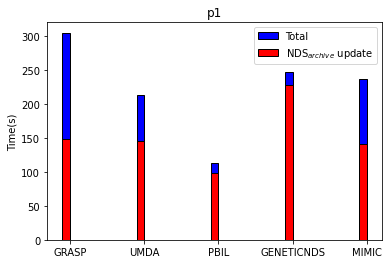

Mean percentage of total time used to update NDS_archive in each algorithm. Dataset: p2.
GRASP: 34.34%
umda: 79.36%
pbil: 86.46%
geneticNDS: 94.26%
mimic: 41.46%


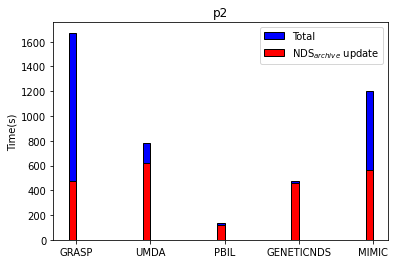

Mean percentage of total time used to update NDS_archive in each algorithm. Dataset: s1.
GRASP: 53.96%
umda: 75.88%
pbil: 88.98%
geneticNDS: 95.22%
mimic: 55.77%


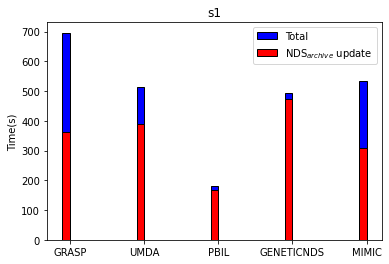

Mean percentage of total time used to update NDS_archive in each algorithm. Dataset: s2.
GRASP: 44.32%
umda: 83.49%
pbil: 89.53%
geneticNDS: 96.96%
mimic: 49.83%


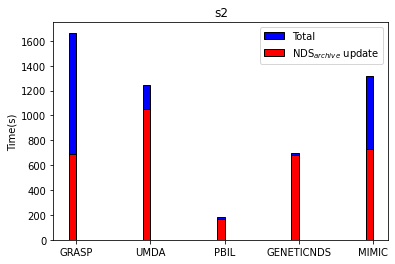

Mean percentage of total time used to update NDS_archive in each algorithm. Dataset: s3.
GRASP: 32.87%
umda: 78.78%
pbil: 87.37%
geneticNDS: 96.0%
mimic: 40.97%


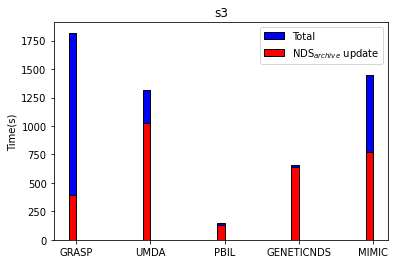

In [38]:
import matplotlib.pyplot as plt

keep_parameters = ['algorithm','sss_per_iteration']
for dataset in datasets_names:
    
    files = []
    files = get_files_for_dataset(dataset)
    df_dataset = getdf_with_params_and_metrics(files=files, keep_parameters=keep_parameters)
    #only keep executions which perform SSS once at the end
    df_dataset_noSSS = df_dataset.loc[df_dataset['sss_per_iteration']==False]

    width = 0.1
    r = np.arange(len(algorithms))
    print(f'Mean percentage of total time used to update NDS_archive in each algorithm. Dataset: {dataset}.')
    for i in np.arange(0, len(algorithms)):
        df_method=df_dataset_noSSS.loc[df_dataset_noSSS['algorithm']==algorithms[i]]
        mean_total_time = np.mean(df_method['time'])
        mean_nds_update__time = np.mean(df_method['nds_update_time'])
        percents = (df_method['nds_update_time']*100)/df_method['time'] 
        mean_percents = np.mean(percents)
        plt.bar(i,mean_total_time , color = 'b', width = width, edgecolor = 'black', label="Total")
        plt.bar(i,mean_nds_update__time , color = 'r', width = width, edgecolor = 'black',  label=r"NDS$_{archive}$ update")
        print(f'{algorithms[i]}: {round(mean_percents,2)}%')
    plt.title(dataset)
    plt.ylabel("Time(s)")
    plt.xticks(r + width/2,[x.upper() for x in algorithms])
    #remove repeated legend labels
    handles, labels = plt.gca().get_legend_handles_labels() 
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.show()

#display(df_method)



#### 4.2 Total time with SSS once Vs Total time with SSS per iteration

In [43]:
def get_metric_differences(filtered_df, with_SSS_per_it, with_SSS_at_end, percents, metric): #at this point, filtered_df only has 2 rows: one with SSS per it = True and other False.
    if filtered_df.shape[0]>2: raise Exception("filtered dataframe whould only have 2 rows.")
    if filtered_df.shape[0]==2: #si no hay 2 es pq un experimento aún no haya acabado
        x1 = filtered_df[filtered_df.sss_per_iteration == True].iloc[0][metric] # get first (and only) row with this column to True
        x2 = filtered_df[filtered_df.sss_per_iteration == False].iloc[0][metric] # get first (and only) row with this column to False
        with_SSS_per_it = with_SSS_per_it + [x1]
        with_SSS_at_end = with_SSS_at_end + [x2]
        #differences =  differences + [x2 - x1]
        percents = percents + [((x2-x1)*100)/x2]
    return with_SSS_per_it, with_SSS_at_end,  percents

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon

def compute_metric_change(metric, precision):

    grasp_hyperparams = ['algorithm','subset_size',"sss_type", "sss_per_iteration", "iterations", "solutions_per_iteration", "path_relinking_mode"]
    pbil_umda_hyperparams = ['algorithm','subset_size',"sss_type", "sss_per_iteration", "population_length", "max_generations"]
    geneticnds_hyperparams = ['algorithm','subset_size',"sss_type", "sss_per_iteration", "population_length", "max_generations", 'mutation_prob']
    mimic_hyperparams = ['algorithm','subset_size',"sss_type", "sss_per_iteration", "population_length", "max_generations", 'selected_individuals']


    for dataset in datasets_names:
        files = get_files_for_dataset(dataset)
        boxplot_df = pd.DataFrame(columns=['algorithm', 'sss_per_it', metric])
        print("MEAN VALUES")
        print(f"Algorithm\t% delta\t{metric} before\t{metric} after\twilcoxon paired test")
        for temp_alg in algorithms: 
            percents, with_SSS_per_it, with_SSS_at_end = ([] for i in range(3))
            if temp_alg in ["pbil","umda"]:
                hyp = pbil_umda_hyperparams
            if temp_alg=="GRASP":
                hyp = grasp_hyperparams
            if temp_alg=="geneticNDS":
                hyp = geneticnds_hyperparams
            if temp_alg=="mimic":
                hyp = mimic_hyperparams
            
            df_dataset = getdf_with_params_and_metrics(files=files, keep_parameters=hyp)
            df_alg = df_dataset.loc[df_dataset['algorithm']==temp_alg]
            
            if temp_alg=="GRASP":
                for it1 in df_alg["iterations"].unique():
                    for it2 in df_alg["solutions_per_iteration"].unique():
                        for it3 in df_alg["path_relinking_mode"].unique():
                            filtered_df = df_alg[(df_alg['iterations']==it1) & (df_alg['solutions_per_iteration']==it2) & (df_alg['path_relinking_mode']==it3)]
                            if it3==None:
                                filtered_df = df_alg[(df_alg['iterations']==it1) & (df_alg['solutions_per_iteration']==it2) & (df_alg['path_relinking_mode'].isna())]
                            with_SSS_per_it, with_SSS_at_end, percents = get_metric_differences(filtered_df, with_SSS_per_it, with_SSS_at_end, percents,metric)
                
            
            
            if temp_alg =="pbil":
                for it1 in df_alg["population_length"].unique():
                    for it2 in df_alg["max_generations"].unique():
                            filtered_df = df_alg[(df_alg['population_length']==it1) & (df_alg['max_generations']==it2)]
                            with_SSS_per_it, with_SSS_at_end, percents = get_metric_differences(filtered_df, with_SSS_per_it, with_SSS_at_end, percents,metric)
                                    
                    

            if temp_alg =="umda":
                for it1 in df_alg["population_length"].unique():
                    for it2 in df_alg["max_generations"].unique():
                            filtered_df = df_alg[(df_alg['population_length']==it1) & (df_alg['max_generations']==it2)]
                            with_SSS_per_it, with_SSS_at_end, percents = get_metric_differences(filtered_df, with_SSS_per_it, with_SSS_at_end, percents,metric)
            

            if temp_alg == "geneticNDS":
                for it1 in df_alg["population_length"].unique():
                    for it2 in df_alg["max_generations"].unique():
                        for it3 in df_alg["mutation_prob"].unique():
                            filtered_df = df_alg[(df_alg['population_length']==it1) & (df_alg['max_generations']==it2) & (df_alg['mutation_prob']==it3)]
                            with_SSS_per_it, with_SSS_at_end, percents = get_metric_differences(filtered_df, with_SSS_per_it, with_SSS_at_end, percents,metric)
            

            if temp_alg == "mimic":
                for it1 in df_alg["population_length"].unique():
                    for it2 in df_alg["max_generations"].unique():
                        for it3 in df_alg["selected_individuals"].unique():
                            filtered_df = df_alg[(df_alg['population_length']==it1) & (df_alg['max_generations']==it2) & (df_alg['selected_individuals']==it3)]
                            with_SSS_per_it, with_SSS_at_end, percents = get_metric_differences(filtered_df, with_SSS_per_it, with_SSS_at_end, percents, metric)
                
                
            print(f"{temp_alg}\t{round(np.mean(percents),2)}%\t{round(np.mean(with_SSS_at_end),precision)}\t{round(np.mean(with_SSS_per_it),precision)}\t{wilcoxon(with_SSS_at_end,with_SSS_per_it).pvalue}")
            for temp_metric in with_SSS_at_end:
                boxplot_df = boxplot_df.append({'algorithm':temp_alg, 'sss_per_it': False, metric:temp_metric}, ignore_index=True)
            for temp_metric in with_SSS_per_it:
                boxplot_df = boxplot_df.append({'algorithm':temp_alg, 'sss_per_it': True, metric:temp_metric}, ignore_index=True)

        
        sns.boxplot(x="algorithm", hue="sss_per_it", y=metric, data=boxplot_df).set(title=dataset)
        plt.show()

MEAN VALUES
Algorithm		% delta	time before	time after	wilcoxon paired test
GRASP		4.53%	305.34	270.26	0.00022216596965950796
umda		17.99%	214.18	166.55	5.960464477539063e-08
pbil		27.35%	112.74	64.78	2.980232238769531e-07
geneticNDS		58.69%	247.17	85.47	7.556929455863566e-10
mimic		11.65%	237.17	193.58	1.016310324350643e-07


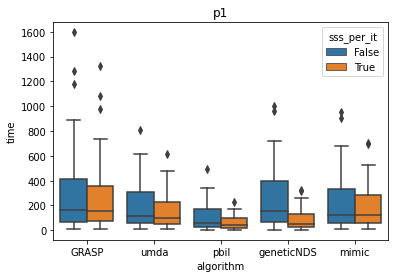

MEAN VALUES
Algorithm		% delta	time before	time after	wilcoxon paired test
GRASP		10.8%	1672.34	1394.25	1.6310100430962223e-09
umda		43.6%	781.39	402.44	5.960464477539063e-08
pbil		50.91%	132.85	52.66	5.960464477539063e-08
geneticNDS		68.12%	478.82	117.92	7.556929455863566e-10
mimic		24.44%	1201.66	925.32	7.556929455863566e-10


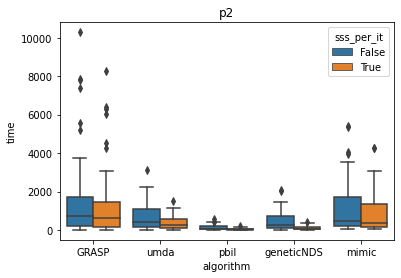

MEAN VALUES
Algorithm		% delta	time before	time after	wilcoxon paired test
GRASP		19.76%	696.31	524.0	8.031090907046913e-10
umda		35.35%	512.52	310.15	5.960464477539063e-08
pbil		49.33%	181.02	65.79	5.960464477539063e-08
geneticNDS		73.12%	492.75	102.89	7.556929455863566e-10
mimic		18.46%	534.76	436.2	7.556929455863566e-10


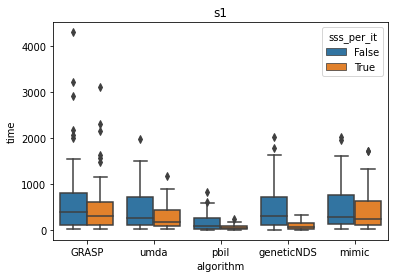

MEAN VALUES
Algorithm		% delta	time before	time after	wilcoxon paired test
GRASP		16.87%	1665.09	1205.14	1.1100954635085601e-09
umda		56.16%	1241.42	478.51	5.960464477539063e-08
pbil		49.96%	184.17	70.35	5.960464477539063e-08
geneticNDS		80.76%	698.26	95.14	7.556929455863566e-10
mimic		27.31%	1316.47	948.75	7.556929455863566e-10


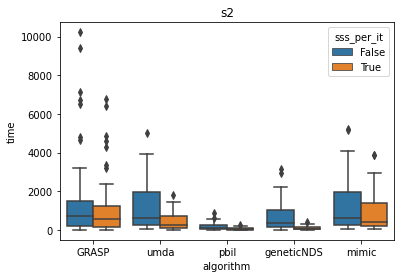

MEAN VALUES
Algorithm		% delta	time before	time after	wilcoxon paired test
GRASP		13.92%	1819.29	1459.27	1.120159643476778e-08
umda		45.76%	1318.48	686.16	5.960464477539063e-08
pbil		55.11%	146.56	53.89	5.960464477539063e-08
geneticNDS		74.38%	660.85	121.81	7.556929455863566e-10
mimic		31.35%	1448.6	849.87	1.6310100430962223e-09


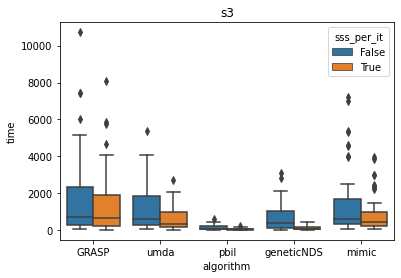

In [58]:
compute_metric_change('time',2)

### 4.3 Change in HV and gd+ after applying SSS per iteration instead of only once at the end.

Change in HV (positive percent means HV was greater before change):
MEAN VALUES
Algorithm	% delta	HV before	HV after	wilcoxon paired test
GRASP	0.0%	0.99305	0.99305	0.680947047583621
umda	0.01%	0.97217	0.97208	3.1948089599609375e-05
pbil	-1.31%	0.95685	0.96914	5.960464477539063e-08
geneticNDS	0.01%	0.94183	0.9417	6.023629494981426e-09
mimic	0.0%	0.99239	0.99239	0.20115248605459868


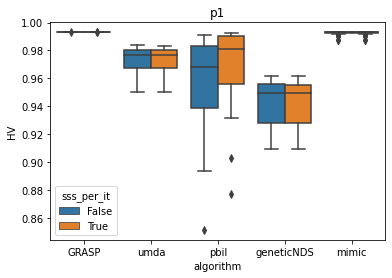

MEAN VALUES
Algorithm	% delta	HV before	HV after	wilcoxon paired test
GRASP	-0.01%	0.8765	0.87658	0.3453729924798057
umda	0.2%	0.80577	0.80417	5.960464477539063e-08
pbil	-11.55%	0.53538	0.59813	5.960464477539063e-08
geneticNDS	0.05%	0.69818	0.69781	7.556929455863566e-10
mimic	0.18%	0.83375	0.83226	7.514318919004358e-10


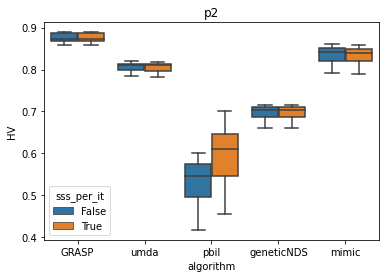

MEAN VALUES
Algorithm	% delta	HV before	HV after	wilcoxon paired test
GRASP	0.02%	0.88473	0.88453	0.002638429681386069
umda	0.04%	0.84284	0.84253	1.233816146850586e-05
pbil	-6.71%	0.73153	0.77991	5.960464477539063e-08
geneticNDS	0.04%	0.76328	0.76296	8.53422673646545e-10
mimic	0.06%	0.87409	0.87355	7.514318919004358e-10


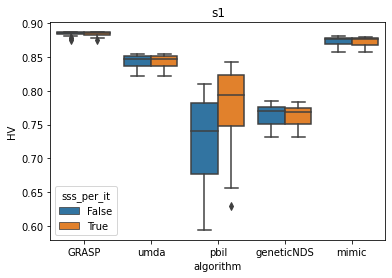

MEAN VALUES
Algorithm	% delta	HV before	HV after	wilcoxon paired test
GRASP	-0.03%	0.8083	0.80851	0.92471253931355
umda	0.17%	0.76836	0.76703	5.960464477539063e-08
pbil	-11.46%	0.53576	0.59762	5.960464477539063e-08
geneticNDS	0.05%	0.67033	0.67003	7.556929455863566e-10
mimic	0.14%	0.78556	0.78442	7.514318919004358e-10


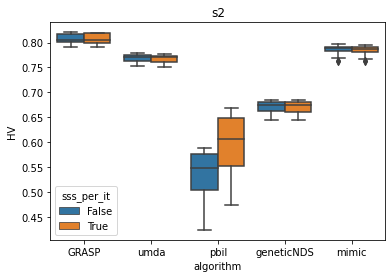

MEAN VALUES
Algorithm	% delta	HV before	HV after	wilcoxon paired test
GRASP	-0.17%	0.85113	0.85261	0.07392246519670155
umda	0.23%	0.77937	0.77759	5.960464477539063e-08
pbil	-12.0%	0.47051	0.52726	5.960464477539063e-08
geneticNDS	0.05%	0.66672	0.66638	1.5591448621045152e-09
mimic	0.2%	0.79765	0.79602	1.6214297824395576e-09


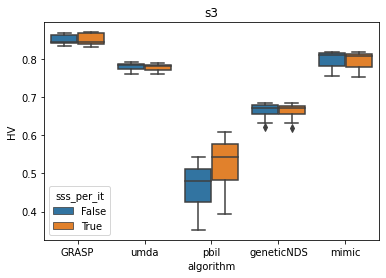

In [55]:
print("Change in HV (positive percent is worse):")
compute_metric_change('HV',5)

Change in GD (positive percent means GD+ was greater before change):
MEAN VALUES
Algorithm	% delta	gdplus before	gdplus after	wilcoxon paired test
GRASP	1.93%	0.0	0.0	0.1805709201832777
umda	1.99%	0.00466	0.00452	0.010510802268981934
pbil	62.94%	0.002	0.00133	0.00018787384033203125
geneticNDS	4.97%	0.01204	0.01145	8.031090907046913e-10
mimic	-727854485230.58%	2e-05	2e-05	0.06148993318225923


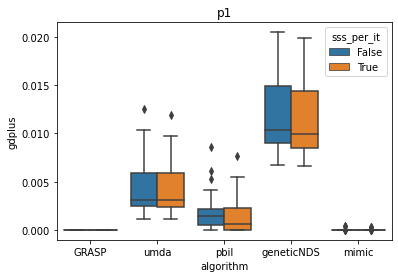

MEAN VALUES
Algorithm	% delta	gdplus before	gdplus after	wilcoxon paired test
GRASP	5.12%	0.00938	0.00909	0.5657197991441898
umda	8.54%	0.04566	0.04178	5.960464477539063e-08
pbil	-8.77%	0.02074	0.02256	5.245208740234375e-06
geneticNDS	9.01%	0.06786	0.06166	7.556929455863566e-10
mimic	7.92%	0.02833	0.02677	5.338659416170757e-09


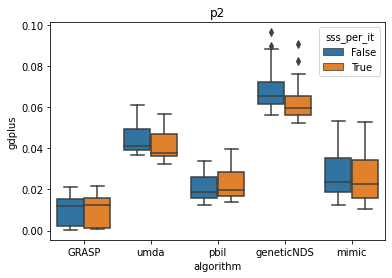

MEAN VALUES
Algorithm	% delta	gdplus before	gdplus after	wilcoxon paired test
GRASP	-14535097642629.02%	0.0008	0.00092	1.4992617020836475e-08
umda	8.41%	0.01967	0.01793	5.960464477539063e-08
pbil	16.9%	0.00671	0.00601	0.0005564093589782715
geneticNDS	5.07%	0.04458	0.0423	7.556929455863566e-10
mimic	4.5%	0.00473	0.00449	2.082207377913472e-06


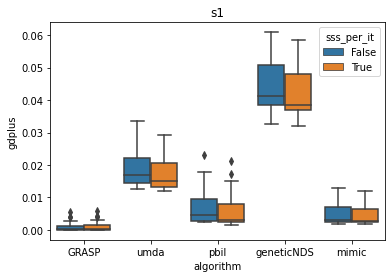

MEAN VALUES
Algorithm	% delta	gdplus before	gdplus after	wilcoxon paired test
GRASP	12.65%	0.00914	0.00877	0.42327221109755275
umda	10.24%	0.03204	0.02872	5.960464477539063e-08
pbil	-5.65%	0.01409	0.01489	0.0003764033317565918
geneticNDS	2.33%	0.0529	0.0517	1.7742215632018938e-08
mimic	12.37%	0.02037	0.01803	7.514318919004358e-10


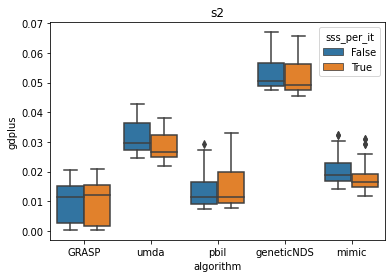

MEAN VALUES
Algorithm	% delta	gdplus before	gdplus after	wilcoxon paired test
GRASP	22.6%	0.01383	0.01272	0.012866608256365713
umda	7.03%	0.05278	0.04896	5.960464477539063e-08
pbil	-9.33%	0.02602	0.02832	5.960464477539062e-07
geneticNDS	4.78%	0.07493	0.07137	7.556929455863566e-10
mimic	6.69%	0.03977	0.03765	4.154336851713959e-09


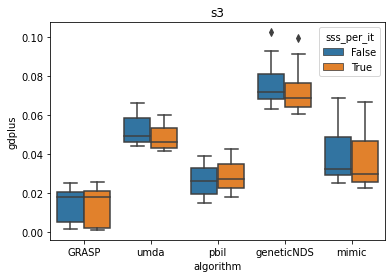

In [56]:
print("Change in GD (positive percent is worse):")
compute_metric_change('gdplus',5)

Change in spread (positive percent is better):
MEAN VALUES
Algorithm	% delta	spread before	spread after	wilcoxon paired test


c:\Users\Pablo.Bermejo\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


GRASP	0.0%	0.51903	0.51903	1.0
umda	-0.54%	0.58929	0.59244	0.02550506591796875
pbil	4.11%	0.61366	0.58788	0.0067255496978759766
geneticNDS	-1.03%	0.63847	0.645	1.1962409574708818e-08
mimic	-0.05%	0.52669	0.52694	0.0735206558585311


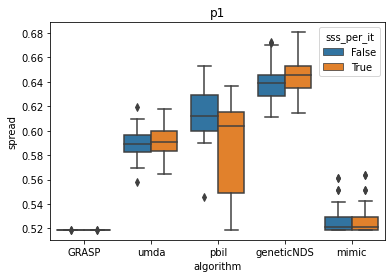

MEAN VALUES
Algorithm	% delta	spread before	spread after	wilcoxon paired test
GRASP	-0.75%	0.60362	0.60807	0.03924911482773547
umda	-6.78%	0.59602	0.63619	5.960464477539063e-08
pbil	-1.41%	0.58007	0.58789	0.10731470584869385
geneticNDS	-3.14%	0.71956	0.74215	7.556929455863566e-10
mimic	-2.22%	0.61049	0.62376	1.626527377784617e-05


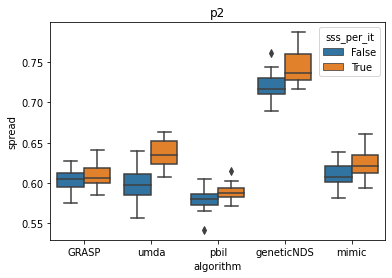

MEAN VALUES
Algorithm	% delta	spread before	spread after	wilcoxon paired test
GRASP	-0.49%	0.55113	0.55383	0.03749971565959912
umda	-2.14%	0.59284	0.60539	1.233816146850586e-05
pbil	0.74%	0.5917	0.58671	0.24106645584106445
geneticNDS	-1.71%	0.64306	0.65408	2.1002250112728297e-09
mimic	-0.54%	0.57862	0.58164	0.054090694814000174


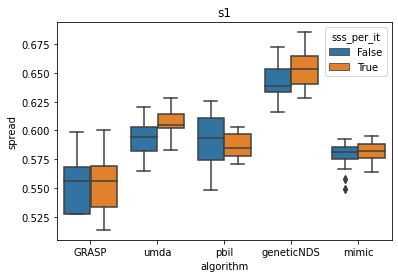

MEAN VALUES
Algorithm	% delta	spread before	spread after	wilcoxon paired test
GRASP	-0.95%	0.60348	0.60907	0.12432832661958342
umda	-2.92%	0.59449	0.61151	1.5079975128173828e-05
pbil	-0.82%	0.58757	0.59218	0.17295855283737183
geneticNDS	-0.21%	0.64279	0.64412	0.18761329108286695
mimic	-2.12%	0.60504	0.61766	4.049297881563014e-08


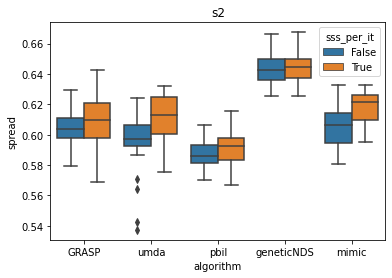

MEAN VALUES
Algorithm	% delta	spread before	spread after	wilcoxon paired test
GRASP	-1.18%	0.60094	0.60783	0.010470532462444664
umda	-6.93%	0.56851	0.60774	5.960464477539063e-08
pbil	-2.06%	0.58505	0.59691	0.0005564093589782715
geneticNDS	-1.03%	0.70365	0.71083	3.6788466701129835e-06
mimic	-3.51%	0.60011	0.62109	6.393684445600466e-09


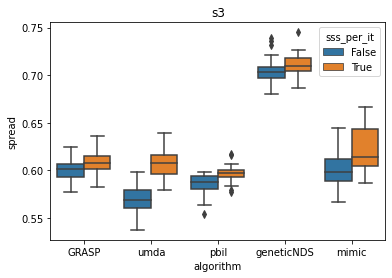

In [61]:
print("Change in spread (positive percent is better):")
compute_metric_change('spread',5)

## 5 Plots of algorithms' NDS with their best configuration applying SSS per iteration